In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from src import *
from sklearn.mixture import GaussianMixture
import pandas as pd
import numpy as np 
import pylab 
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
sns.set_style("whitegrid")

### Load data

In [2]:
# load volume data
df = pd.read_excel("data/TICKER_TURNOVERS_COMBINED.xlsx")
df["log_vol"] = np.log(df["Normalized_TURNOVER"])
print(df.head())

# Ensure proper parsing of datetime and other columns
df['date'] = pd.to_datetime(df['date']).dt.date
df['time'] = pd.to_datetime(df['time']).dt.time

# Get unique values for indexing
unique_tickers = df['TICKER'].unique()
unique_dates = df['date'].unique()
unique_times = df['time'].unique()

# Create mapping from tickers, dates, and times to indices
ticker_index = {ticker: idx for idx, ticker in enumerate(unique_tickers)}
date_index = {date: idx for idx, date in enumerate(unique_dates)}
time_index = {time: idx for idx, time in enumerate(unique_times)}

# Initialize a 3D numpy array to store log_vol values
num_tickers = len(unique_tickers)
num_dates = len(unique_dates)
num_times = len(unique_times)
log_vol_array = np.full((num_tickers, num_dates, num_times), np.nan)  # Using NaN for missing values

# Fill the numpy array with log_vol values
for _, row in df.iterrows():
    ticker_idx = ticker_index[row['TICKER']]
    date_idx = date_index[row['date']]
    time_idx = time_index[row['time']]
    log_vol_array[ticker_idx, date_idx, time_idx] = row['log_vol']

# Check that all values are present
assert np.all(np.isfinite(log_vol_array))

print(log_vol_array.shape)

        date      time TICKER      TURNOVER  Normalized_TURNOVER   log_vol
0 2023-02-01  09:00:00   AAPL  1.103893e+09             0.145584 -1.927002
1 2023-02-01  10:00:00   AAPL  1.275860e+09             0.168263 -1.782225
2 2023-02-01  11:00:00   AAPL  7.645183e+08             0.100826 -2.294355
3 2023-02-01  12:00:00   AAPL  8.913491e+08             0.117553 -2.140864
4 2023-02-01  13:00:00   AAPL  7.059671e+08             0.093105 -2.374032


/var/folders/np/dsy1lclj23v2c_d9w08mxsmh0000gn/T/ipykernel_55502/2421051964.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time']).dt.time


(10, 230, 7)


### Manually find and remove outliers

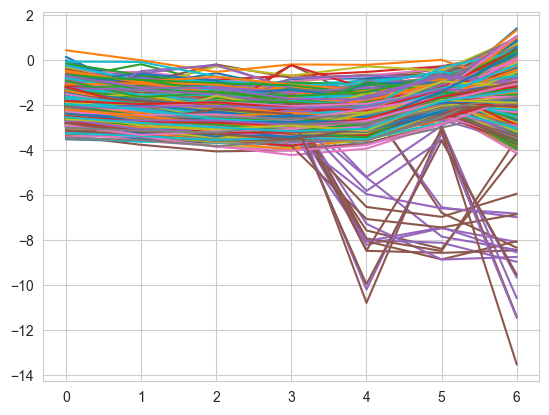

2 (10, 228, 7)
104    2023-02-22
205    2023-03-15
Name: date, dtype: object


In [3]:
bad_days = set()
plt.figure()
for a in range(log_vol_array.shape[0]):
    for i in range(log_vol_array.shape[1]):
        d = log_vol_array[a, i, :]
        if np.any(d < -5):
            bad_days.add(i)
        plt.plot(d)
plt.show()

log_vol_array = np.delete(log_vol_array, list(bad_days), axis=1)
num_dates = log_vol_array.shape[1]
print(len(bad_days), log_vol_array.shape)
print(df["date"].iloc[list(bad_days)])

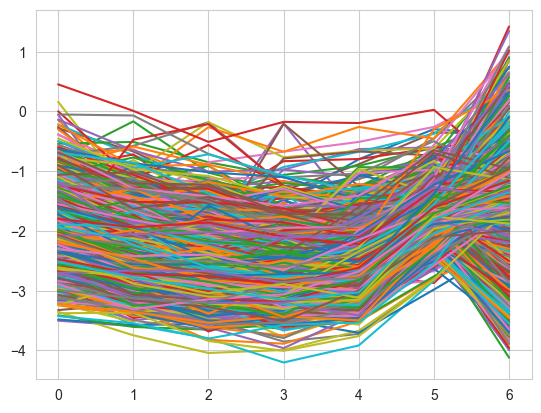

In [4]:
plt.figure()
for a in range(log_vol_array.shape[0]):
    for i in range(log_vol_array.shape[1]):
        d = log_vol_array[a, i, :]
        plt.plot(d)
plt.show()


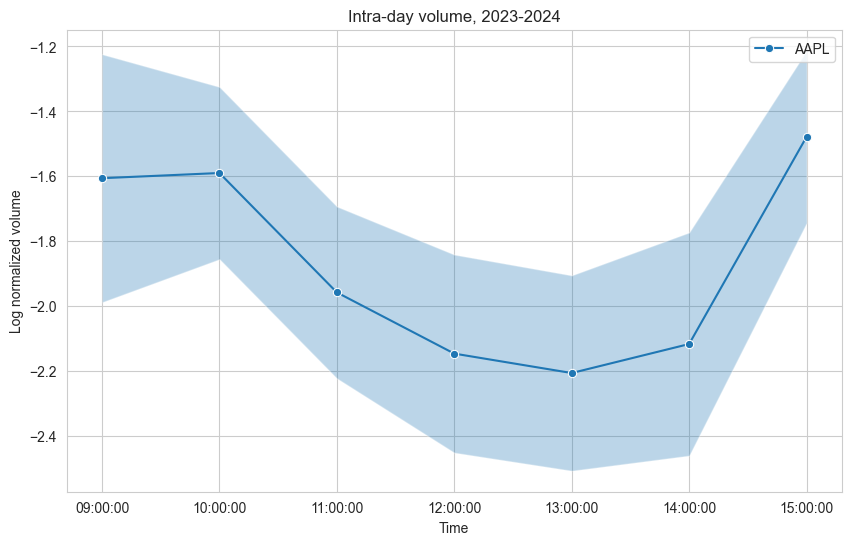

In [5]:
plt.figure(figsize=(10, 6))

for a in [0,]:
    std_devs = np.std(log_vol_array[a], axis=0)
    means = np.mean(log_vol_array[a], axis=0)

    # Create a DataFrame for plotting
    df = pd.DataFrame({
        'Time': np.arange(log_vol_array.shape[2]),
        'Log normalized volume': means,
        'StdDev': std_devs
    })
    sns.lineplot(x='Time', y='Log normalized volume', data=df, marker='o', label=unique_tickers[a])
    plt.fill_between(df['Time'], df['Log normalized volume'] - df['StdDev'], df['Log normalized volume'] + df['StdDev'], alpha=0.3)

plt.title("Intra-day volume, 2023-2024")
# plt.legend()
plt.xticks(np.arange(num_times), [str(t) for t in unique_times])
plt.savefig("figures/aapl_volume.png")
plt.show()

In [6]:
# standardize the data
log_vol_array = log_vol_array - np.mean(log_vol_array, axis=1, keepdims=True)
log_vol_array /= np.std(log_vol_array, axis=1, keepdims=True)

### Functions to fit prior distributions and generate volume predictors

In [7]:
MAX_COMPONENTS = 5
COMPONENTS_STEP = 1
RANK_STEP = 1

def tune_num_components(method, fit_data, val_data, **args):
    """Tune the number of components in the given method using the validation
    data."""

    def _fit_with_n_components(n_components):
        try:
            prior = method(n_components=int(n_components), **args)
            prior.fit(fit_data)
            pred = GaussianMixtureVolume(prior)
            score = np.sum(evaluate_predictor(pred, val_data))
        except:
            score = -np.inf

        return n_components, score

    best_n_components = 1
    best_score = -np.inf
    for n_components in tqdm(range(2, MAX_COMPONENTS + 1, COMPONENTS_STEP)):
        score = _fit_with_n_components(n_components)
        if score > best_score:
            best_score = score
            best_n_components = n_components

    return best_n_components


def tune_components_and_rank(method, fit_data, val_data, **args):
    """TUne the number of components and the rank of the factor model in the
    given method using the validation data."""

    def _fit_with_n_and_rank(n_components, rank):
        try:
            prior = method(n_components=int(n_components), rank=int(rank), **args)
            prior.fit(fit_data)
            pred = GaussianMixtureVolume(prior)
            score = np.sum(evaluate_predictor(pred, val_data))
        except:
            score = -np.inf

        print(n_components, rank, score)
        return score

    best_n_components = 1
    best_rank = fit_data.shape[1]
    best_score = -np.inf
    for n_components, rank in tqdm(zip(range(2, MAX_COMPONENTS + 1, COMPONENTS_STEP), range(1, fit_data.shape[1] + 1, RANK_STEP))):
        score = _fit_with_n_and_rank(n_components, rank)
        if score > best_score:
            best_score = score
            best_n_components = n_components
            best_rank = rank

    return best_n_components, best_rank


def generate_priors(fit_data, val_data=None, num_components=None, rank=None):
    """Fit a variety of volume priors to the data."""
    priors = {}

    tune_n = num_components is None
    tune_rank = rank is None

    # simple gaussian model
    gau = GaussianMixture(n_components=1)
    gau.fit(fit_data)
    priors["Gaussian"] = gau

    if tune_n:
        num_components = tune_num_components(GaussianMixture, fit_data, val_data)
        print(f"GaussianMixture: {num_components} components")

    gmm = GaussianMixture(n_components=num_components)
    gmm.fit(fit_data)
    priors["GMM"] = gmm

    # gmm with factor model constraint on covariances at every EM step
    if tune_n or tune_rank:
        num_components, rank = tune_components_and_rank(GaussianFactorMixture, fit_data, val_data, metric="kl")
        print(f"GaussianFactorMixture kl: {num_components} components, rank {rank}")
    gmm_factor_kl = GaussianFactorMixture(n_components=num_components, rank=rank, metric="kl")
    gmm_factor_kl.fit(fit_data)
    priors["MoF with KL factor fitting"] = gmm_factor_kl

    if tune_n or tune_rank:
        num_components, rank = tune_components_and_rank(GaussianFactorMixture, fit_data, val_data, metric="frob")
        print(f"GaussianFactorMixture frob: {num_components} components, rank {rank}")
    gmm_factor_frob = GaussianFactorMixture(n_components=num_components, rank=rank, metric="frob")
    gmm_factor_frob.fit(fit_data)
    priors["MoF with Frobenius factor fitting"] = gmm_factor_frob

    return priors


def generate_predictors(priors, fit_data):
    """Generate volume predictors using the given priors, plus a baseline linear
    regression predictor."""
    predictors = {}

    # linear regression
    lr = LinearRegressionVolume(7)
    lr.fit(fit_data)
    predictors["Linear Regression"] = lr

    for key, prior in priors.items():
        predictors[key] = GaussianMixtureVolume(prior)

    return predictors


def evaluate_predictor(predictor, eval_data):
    """Evaluate the given predictor on the test data."""
    n_assets = eval_data.shape[1] // 7
    calc_mse = lambda pred, true: np.mean(np.square(true - pred))
    mse = [calc_mse(predictor.predict(), eval_data)]
    for i in range(7 - 1):
        mse.append(calc_mse(predictor.predict(eval_data[:, : n_assets * (i + 1)]), eval_data[:, n_assets * (i + 1) :]))
    return mse

### Asset-stratified volume prediction

In [8]:
# train-val-test split
inds = np.arange(num_dates)
np.random.shuffle(inds)

train_inds = np.sort(inds[:3 * num_dates // 4])
val_inds = np.sort(inds[3*num_dates // 4:3*num_dates // 4+num_dates // 8])
test_inds = np.sort(inds[7 * num_dates // 8:])

train_data = np.ascontiguousarray(log_vol_array[:, train_inds, :])
val_data = np.ascontiguousarray(log_vol_array[:, val_inds, :])
test_data = np.ascontiguousarray(log_vol_array[:, test_inds, :])

# Display the resulting 3D numpy array shape
print(train_data.shape, val_data.shape, test_data.shape)

(10, 171, 7) (10, 28, 7) (10, 29, 7)


Ticker: AAPL
Method: Gaussian
Prior score: -7.4046198731602315
Method: GMM
Prior score: -7.572978489158872
Method: MoF with KL factor fitting
Prior score: -8.034637820770978
Method: MoF with Frobenius factor fitting
Prior score: -7.698459006232065


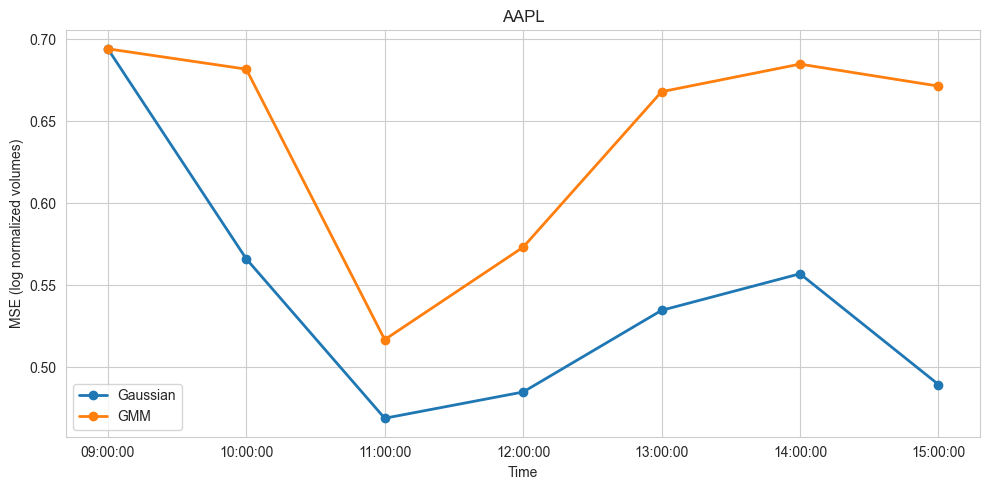

Ticker: AMZN
Method: Gaussian
Prior score: -7.890820456569809
Method: GMM
Prior score: -7.7755085674026345
Method: MoF with KL factor fitting
Prior score: -8.179982930023737
Method: MoF with Frobenius factor fitting
Prior score: -8.15918713807431


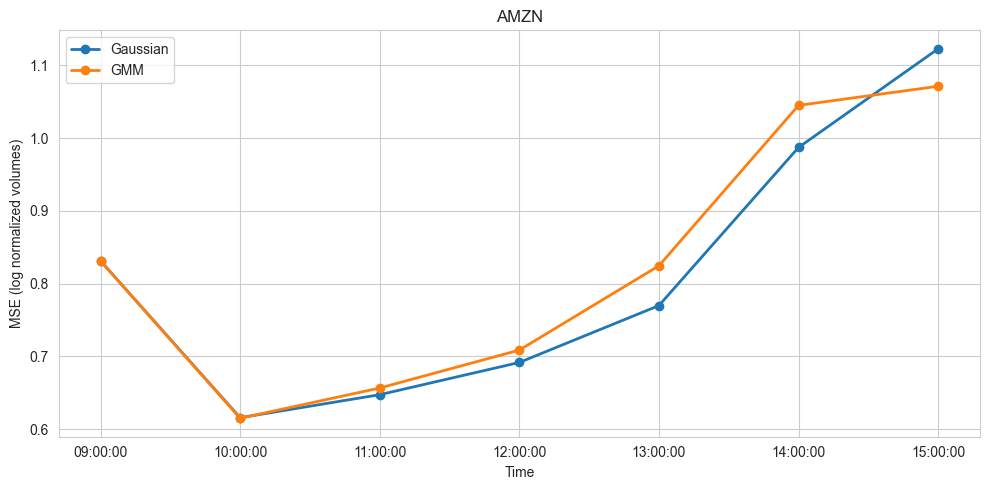

Ticker: GOOG
Method: Gaussian
Prior score: -8.049200713866163
Method: GMM
Prior score: -8.401008790293941
Method: MoF with KL factor fitting
Prior score: -8.204457786729844
Method: MoF with Frobenius factor fitting
Prior score: -8.193701842672153


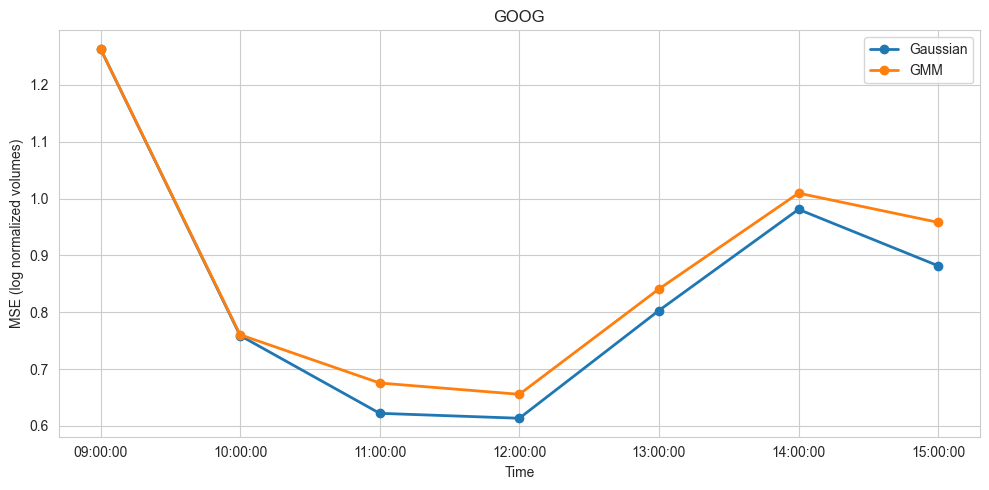

Ticker: JNJ
Method: Gaussian
Prior score: -6.286559543761725
Method: GMM
Prior score: -6.259653067288613
Method: MoF with KL factor fitting
Prior score: -6.456055678002994
Method: MoF with Frobenius factor fitting
Prior score: -6.407176862757502


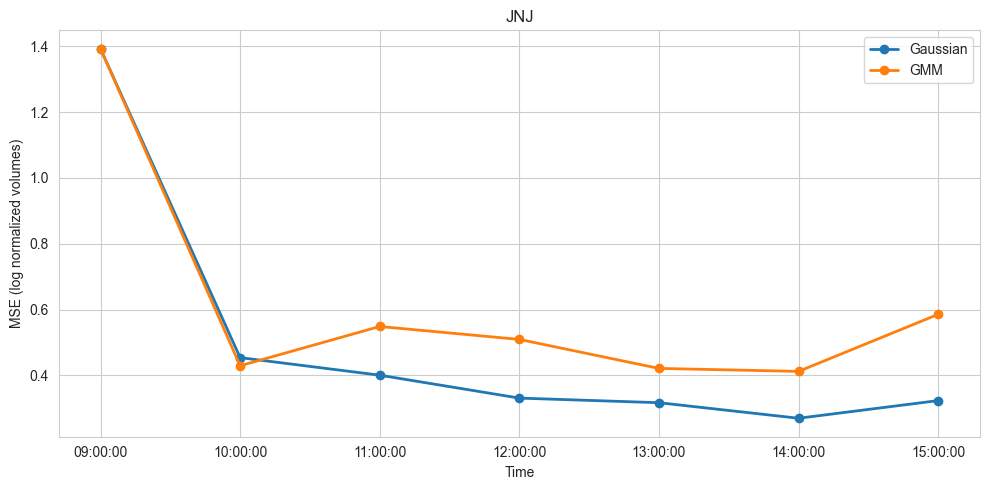

Ticker: META
Method: Gaussian
Prior score: -7.469631792966578
Method: GMM
Prior score: -7.466664393825473
Method: MoF with KL factor fitting
Prior score: -7.897571314884942
Method: MoF with Frobenius factor fitting
Prior score: -7.637432835886464


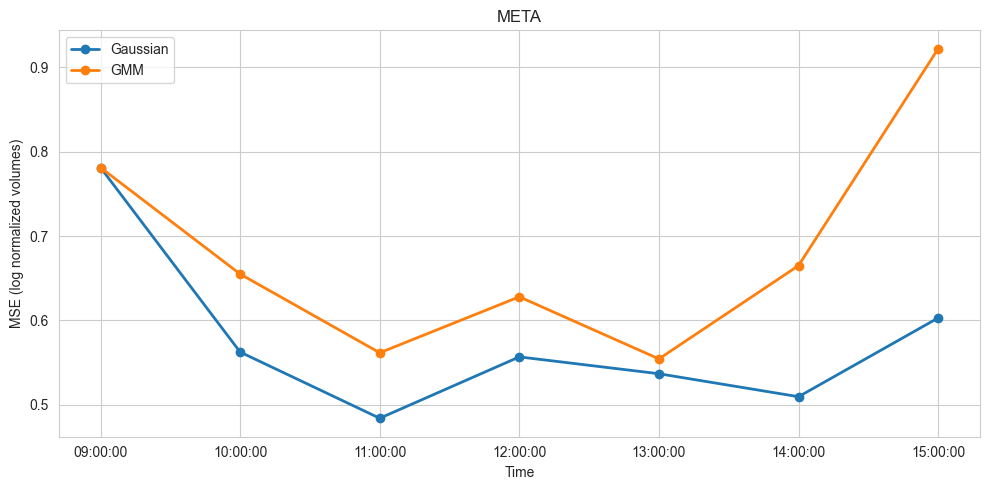

Ticker: MSFT
Method: Gaussian
Prior score: -8.05170786458705
Method: GMM
Prior score: -8.161770718684116
Method: MoF with KL factor fitting
Prior score: -8.14990863898213
Method: MoF with Frobenius factor fitting
Prior score: -8.148418776080188


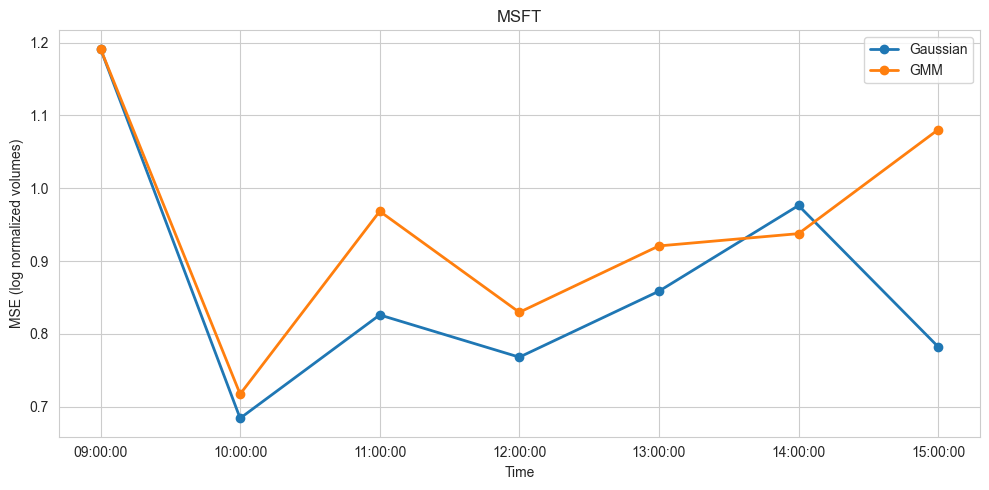

Ticker: NVDA
Method: Gaussian
Prior score: -9.203433712133856
Method: GMM
Prior score: -9.052026166265689
Method: MoF with KL factor fitting
Prior score: -9.167877919385862
Method: MoF with Frobenius factor fitting
Prior score: -9.29719330723359


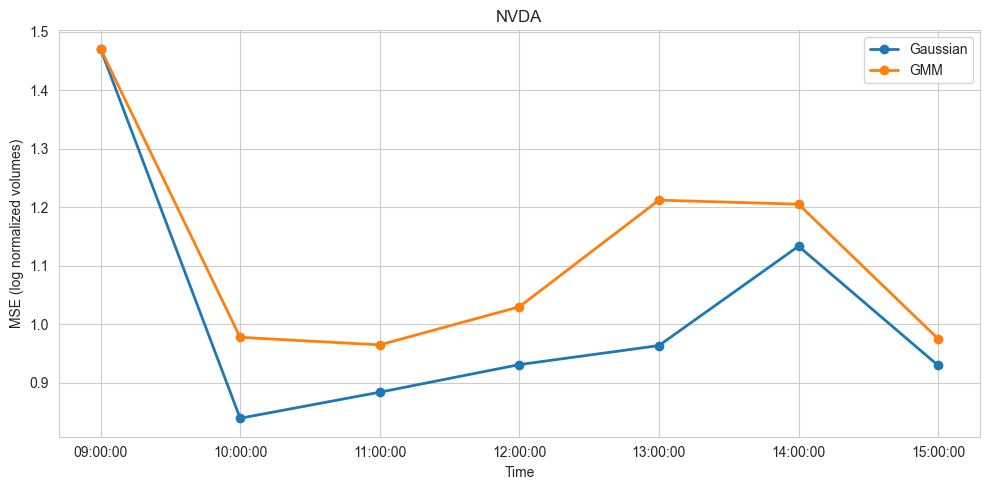

Ticker: TSLA
Method: Gaussian
Prior score: -8.262113688016195
Method: GMM
Prior score: -8.605002636417456
Method: MoF with KL factor fitting
Prior score: -8.553391933548028
Method: MoF with Frobenius factor fitting
Prior score: -9.17848131032102


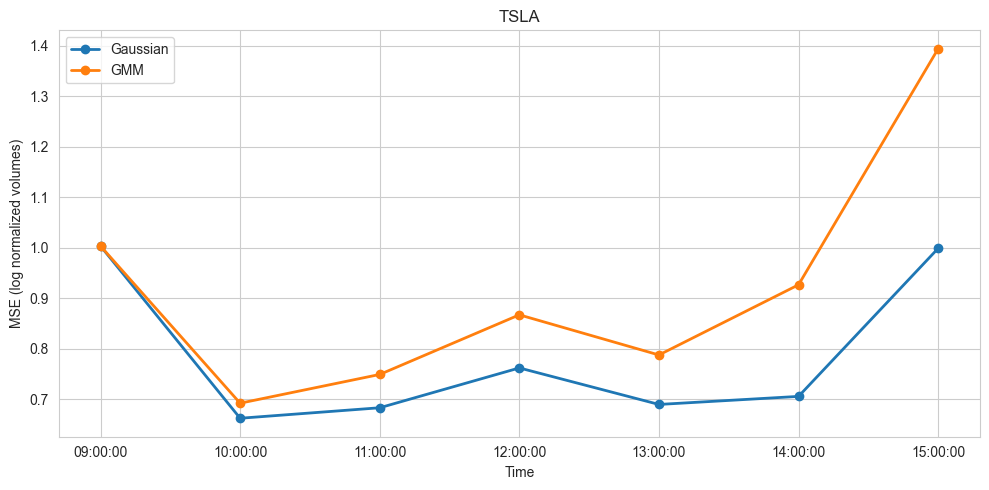

Ticker: UNH
Method: Gaussian
Prior score: -6.86565663865672
Method: GMM
Prior score: -6.7316704416660285
Method: MoF with KL factor fitting
Prior score: -7.182924181478114
Method: MoF with Frobenius factor fitting
Prior score: -7.497613072896399


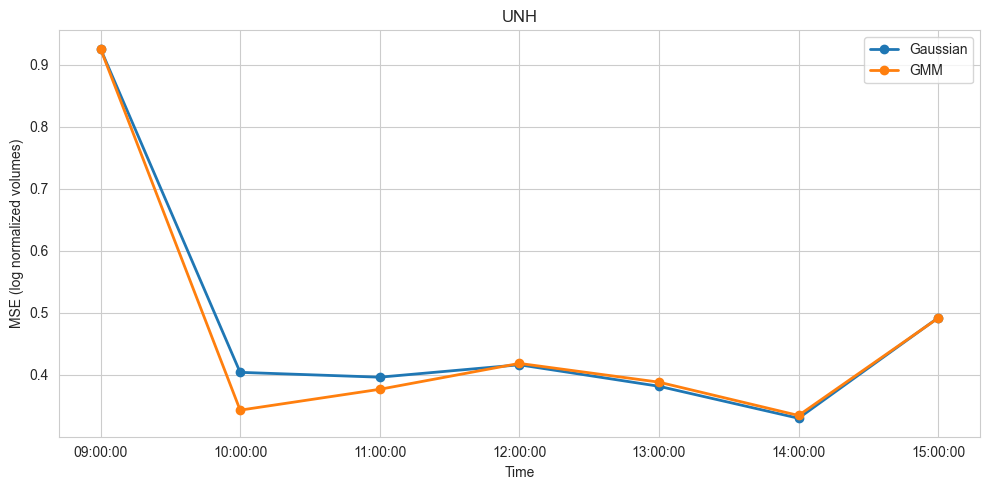

Ticker: XOM
Method: Gaussian
Prior score: -7.819594140257006
Method: GMM
Prior score: -8.06167188513804
Method: MoF with KL factor fitting
Prior score: -8.129393682784748
Method: MoF with Frobenius factor fitting
Prior score: -7.992948211788985


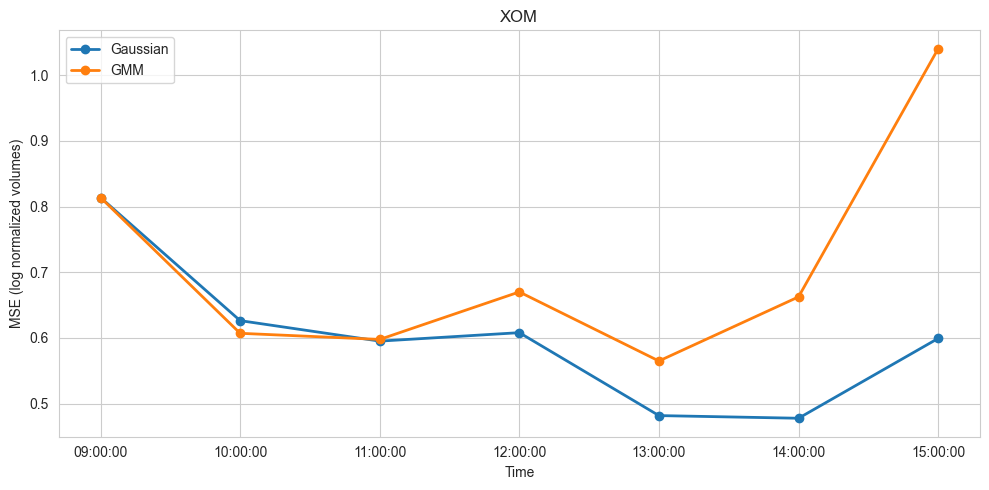

In [10]:
params = {
    "AAPL": {"num_components": 2, "rank": 6},
    "AMZN": {"num_components": 2, "rank": 5},
    "GOOG": {"num_components": 2, "rank": 5},
    "JNJ":  {"num_components": 2, "rank": 5},
    "META": {"num_components": 2, "rank": 5},
    "MSFT": {"num_components": 2, "rank": 5},
    "NVDA": {"num_components": 2, "rank": 5},
    "TSLA": {"num_components": 2, "rank": 5},
    "UNH":  {"num_components": 2, "rank": 5},
    "XOM":  {"num_components": 2, "rank": 5},
}

for a, ticker in enumerate(params.keys()):
    print(f"Ticker: {ticker}")

    priors = generate_priors(train_data[a], **params[ticker])
    predictors = generate_predictors(priors, train_data[a])

    for key, prior in priors.items():
        print(f"Method: {key}")
        print(f"Prior score: {prior.score(test_data[a])}")

    plt.figure(figsize=(10, 5))
    for key, predictor in predictors.items():
        if key in ["Linear Regression", "MoF with KL factor fitting", "MoF with Frobenius factor fitting"]:
            continue
        mse = evaluate_predictor(predictor, test_data[a])
        plt.plot(mse, label=key, lw=2, marker='o')

    plt.title(f"{ticker}")
    plt.xlabel("Time")
    plt.ylabel("MSE (log normalized volumes)")
    plt.xticks(np.arange(num_times), [str(t) for t in unique_times])
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"figures/stratefied_{ticker}_mse.png")
    plt.show()

### Joint volume prediction

In [11]:
log_vol_joint = np.concatenate([log_vol_array[:, i, :].T.flatten().reshape(1, -1) for i in range(log_vol_array.shape[1])], axis=0)

# train-val-test split
inds = np.arange(num_dates)
np.random.shuffle(inds)

train_inds = np.sort(inds[:3 * num_dates // 4])
val_inds = np.sort(inds[3*num_dates // 4:3*num_dates // 4+num_dates // 8])
test_inds = np.sort(inds[7 * num_dates // 8:])

train_data = np.ascontiguousarray(log_vol_joint[train_inds, :])
val_data = np.ascontiguousarray(log_vol_joint[val_inds, :])
test_data = np.ascontiguousarray(log_vol_joint[test_inds, :])

# Display the resulting 3D numpy array shape
print(train_data.shape, val_data.shape, test_data.shape)

(171, 70) (28, 70) (29, 70)


In [19]:
priors = generate_priors(train_data, val_data=val_data, num_components=2, rank=20)
for key, prior in priors.items():
    print(f"Method: {key}")
    print(f"Score: {prior.score(test_data)}")
predictors = generate_predictors(priors, train_data)

Method: Gaussian
Score: -74.57397743309491
Method: GMM
Score: -110.24851133743479
Method: MoF with KL factor fitting
Score: -68.29607015882067
Method: MoF with Frobenius factor fitting
Score: -65.88877338009858


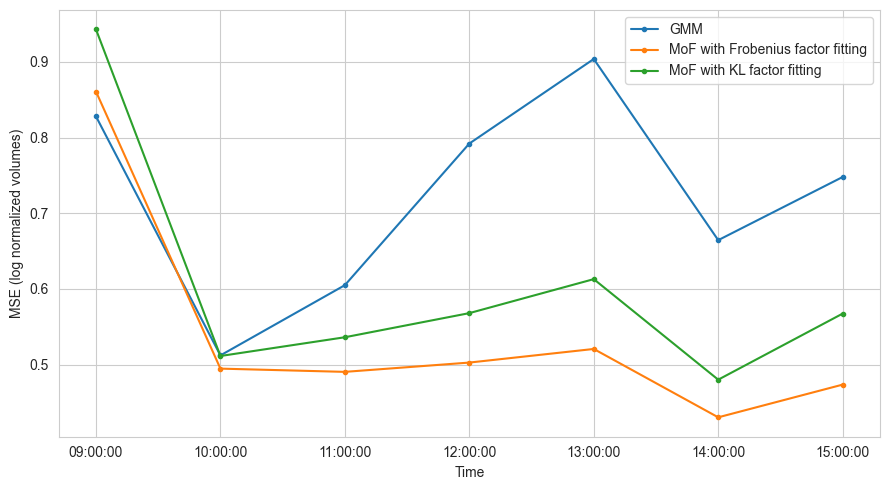

In [27]:
plt.figure(figsize=(9, 5))
plt.plot(evaluate_predictor(predictors["GMM"], test_data), ".-", label="GMM")
plt.plot(evaluate_predictor(predictors["MoF with Frobenius factor fitting"], test_data), ".-", label="MoF with Frobenius factor fitting")
plt.plot(evaluate_predictor(predictors["MoF with KL factor fitting"], test_data), ".-", label="MoF with KL factor fitting")

plt.xlabel("Time")
plt.ylabel("MSE (log normalized volumes)")
plt.xticks(np.arange(num_times), [str(t) for t in unique_times])
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f"figures/joint_mse.png")
plt.show()

### Kalman filter